In [1]:
import sys
sys.path.insert(0, '/das/work/p17/p17983/')

In [2]:
%matplotlib nbagg
import jungfrau_utils as ju
import numpy as np
import json
import os
import time
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

import h5py

from alvra_tools.load_data import *
from alvra_tools.channels import *
from built_functions import *

[INFO][corrections] Numba not available, reverting to Numpy


In [3]:
def get_xes_pumped(filename, DIR, DIRBS, roi, channel, ynstamp):
    numstds = 2.5
    minIzero = 0.01
    lin_filter = 0.2
    image_threshold = 2
    hot_pixel = 6

    print(DIR + filename + ".JF02T09V02crop.h5")
    print()
    print(DIRBS + filename + ".BSREAD.h5")
    
    images_off, images_on, pulse_ids_off, pulse_ids_on = \
        load_JF_cropped_data_pump(DIR + filename + ".JF02T09V02crop.h5", roi, 50, 50/2, nshots=None)
    (DataFluo_pump, DataFluo_unpump, IzeroFEL_pump, IzeroFEL_unpump, JFIDs_pump, JFIDs_unpump, Energy_pump, Energy_unpump, _, _) = \
        load_PumpProbe_events_withTwoVariables(DIRBS + filename + ".BSREAD.h5", channel_BS_pulse_ids, channel)
    (_, _, _, _, _, _, Laser_pump, Laser_unpump, _, _) = \
        load_PumpProbe_events_withTwoVariables(DIRBS + filename + ".BSREAD.h5", channel_PIPS_fluo, channel)
    
    Energy_pump = [x for x in Energy_pump if (np.abs(x) > 0)]
    Energy_eV_pump = np.mean(Energy_pump)
    
    Energy_unpump = [x for x in Energy_unpump if (np.abs(x) > 0)]
    Energy_eV_unpump = np.mean(Energy_unpump)
    
    idcheck = [a==b and c==d for a,b,c,d in zip(pulse_ids_on, JFIDs_pump, pulse_ids_off, JFIDs_unpump)]
    IDCheck = sum([int(x) for x in idcheck])
    
    if IDCheck:
        print("passed ID check")
    else:
        print("failed ID check")   
    
    IzeroMedian = np.median(np.concatenate([IzeroFEL_pump, IzeroFEL_unpump]))
    IzeroSTD = np.std(np.concatenate([IzeroFEL_pump, IzeroFEL_unpump]))
    
#     print('numon')
#     print(IzeroFEL_pump.shape[0])
    
#     print('numoff')
#     print(IzeroFEL_unpump.shape[0])
    
    print('number of frames')
    print(images_on.shape[0])
    print(images_off.shape[0])

    images_good_on = images_on
    images_good_off = images_off

    images_thr_on = images_good_on.copy()
    images_thr_on[images_good_on < image_threshold] = 0
    images_thr_on[images_good_on > hot_pixel] = 0
    images_thr_on[np.isnan(images_thr_on)] = 0
    
    images_thr_off = images_good_off.copy()
    images_thr_off[images_good_off < image_threshold] = 0
    images_thr_off[images_good_off > hot_pixel] = 0
    images_thr_off[np.isnan(images_thr_off)] = 0
    
#     print('num nan')
#     print(sum(sum(sum(np.isnan(images_thr_on)))))
    
#     print('Izero')
#     print(np.mean(IzeroFEL_unpump))
#     print(np.mean(IzeroFEL_pump))
#     print(np.max(IzeroFEL_unpump))
#     print(np.min(IzeroFEL_unpump))
    
    IzeroFEL_pump, IzeroFEL_unpump, DataFluo_pump, DataFluo_unpump, condFinalPump, condFinalUnPump = \
        filterData(IzeroFEL_pump, IzeroFEL_unpump, DataFluo_pump, DataFluo_unpump, numstds, minIzero, lin_filter)
    

    
#     print(images_thr_on.shape)
#     print(images_thr_on.shape)
    
    images_thr_on = images_thr_on[condFinalPump]
    images_thr_off = images_thr_off[condFinalUnPump]

#     print('number of surviving frames')
#     print(images_thr_on.shape[0])
#     print(images_thr_off.shape[0])
    
    XES_on = images_thr_on.sum(axis=0)/images_thr_on.shape[0]
    XES_off = images_thr_off.sum(axis=0)/images_thr_off.shape[0]
    
    XES_on[np.isnan(XES_on)] = 0
    XES_off[np.isnan(XES_off)] = 0
    
#     print('num nan')
#     print(sum(sum(np.isnan(XES_on))))
    
    stamp = make_bar_stamp(XES_on.shape[1],XES_on.shape[0])
    
#     print(XES_on.shape)
#     print(stamp.shape)
    if ynstamp:

        XES_on = XES_on * stamp
        XES_off = XES_off * stamp
        
    FloFEL_pump_total = np.mean(DataFluo_pump)/np.mean(IzeroFEL_pump)
    FloFEL_unpump_total = np.mean(DataFluo_unpump)/np.mean(IzeroFEL_unpump)
    
    return XES_on, XES_off, Energy_eV_pump, Energy_eV_unpump, FloFEL_pump_total, FloFEL_unpump_total


In [4]:
def make_bar_stamp(dimension_x, dimension_y):

    X,Y = np.meshgrid(np.linspace(0,dimension_x-1,dimension_x),np.linspace(0,dimension_y-1,dimension_y))

    Z = np.zeros([dimension_y,dimension_x])+1

    condition = np.logical_and(Y<260, Y>253)
    Z[condition] = 0
    
    Z[Y>320] = 0
    Z[Y < 200] = 0

    condition = np.logical_not(np.logical_and(X<230, X>130))
    Z[condition] = 0

    #plt.figure()
    #plt.imshow(Z)
    
    #plt.colorbar()
    
    return Z

In [5]:
run_list_01_a = np.linspace(501,547,547-501+1)
run_list_01_b = np.linspace(619,677,677-619+1)

run_list_01_a = np.arange(501,547+1)
run_list_01_b = np.arange(619,677+1)
run_list_01 = np.concatenate((run_list_01_a,run_list_01_b), axis = None)
print(run_list_01)

[501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516 517 518
 519 520 521 522 523 524 525 526 527 528 529 530 531 532 533 534 535 536
 537 538 539 540 541 542 543 544 545 546 547 619 620 621 622 623 624 625
 626 627 628 629 630 631 632 633 634 635 636 637 638 639 640 641 642 643
 644 645 646 647 648 649 650 651 652 653 654 655 656 657 658 659 660 661
 662 663 664 665 666 667 668 669 670 671 672 673 674 675 676 677]


Run for RIXS

In [6]:
ynCompare12 = 'yes'
#normalize = False

# folder_name_01 = 'XES_2836.5eV_600fs'
# folder_name_01 = 'XES_2842.0eV_10ps'
# folder_name_01 = 'XES_2836.5eV_600fs'
folder_name_01 = 'XES_2842.0eV_600fs'
# folder_name_01 = 'XES_RuDimerCl_2842.0eV_600fs'
# folder_name_01 = 'XES_RuDimerCl_2837.0eV_600fs'


run_list_01_a = np.arange(461,480+1)
run_list_01_b = np.arange(843,867+1)
run_list_01 = np.concatenate((run_list_01_a,run_list_01_b), axis = None)
print(run_list_01)
run_list_01 = [int(x) for x in run_list_01]






# folder_name_02 = 'XES_2836.5eV_10ps'
folder_name_02 = 'XES_2842.0eV_10ps'
# folder_name_02 = 'XES_RuDimerCl_2842.0eV_10ps
# folder_name_02 = 'XES_RuDimerCl_2837.0eV_10ps'


run_list_02_a = np.arange(481,500+1)
run_list_02_b = np.arange(868,904+1)
run_list_02 = np.concatenate((run_list_02_a,run_list_02_b), axis = None)
run_list_02 = [int(x) for x in run_list_02]
print(run_list_02)







run_list = run_list_01
folder_name = folder_name_01

filename_base = "run_"

DIR = "/das/work/p17/p17983/cropped_data/" + folder_name + "/"
DIRBS = "/sf/alvra/data/p17983/raw/" + folder_name + "/"


iterCounter = 0

for ii in run_list:


    XES_on, XES_off, Energy_eV_pump, Energy_eV_unpump, fluo_pump, fluo_unpump = \
        get_xes_pumped(filename_base + '%06d' % (ii), DIR, DIRBS, 2, channel_energy, True)

    
        
    if False:

        plt.figure()
        plt.subplot(1,2,1)
        plt.title('ON')
        plt.imshow(XES_on, vmax = 0.001)
        plt.colorbar()
        plt.subplot(1,2,2)
        plt.title('OFF')
        plt.imshow(XES_off, vmax = 0.001)
        plt.colorbar()
        plt.tight_layout()

    
    if iterCounter == 0:
        rixs_on = XES_on.sum(axis=0)
        rixs_off = XES_off.sum(axis=0)
    else:
        rixs_on = np.vstack((rixs_on,XES_on.sum(axis=0)))
        rixs_off = np.vstack((rixs_off,XES_off.sum(axis=0)))

    
    
    iterCounter +=1

    
xAxis = np.linspace(1,XES_on.shape[1],XES_on.shape[1])
 
if len(run_list) == 1:
    RIXS_on_01 = rixs_on
    RIXS_off_01 = rixs_off
else:
    RIXS_on_01 = rixs_on.sum(axis=0)
    RIXS_off_01 = rixs_off.sum(axis=0)
    
err_on_01 = np.std(rixs_on, axis = 0)/np.sqrt(rixs_on.shape[0]-1)
err_off_01 = np.std(rixs_off, axis = 0)/np.sqrt(rixs_off.shape[0]-1)

[461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478
 479 480 843 844 845 846 847 848 849 850 851 852 853 854 855 856 857 858
 859 860 861 862 863 864 865 866 867]
[481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904]
/das/work/p17/p17983/cropped_data/XES_2842.0eV_600fs/run_000461.JF02T09V02crop.h5

/sf/alvra/data/p17983/raw/XES_2842.0eV_600fs/run_000461.BSREAD.h5
images_roi2
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
passed ID check
number of frames
2500
2500
/das/work/p17/p17983/cropped_data/XES_2842.0eV_600fs/run_000462.JF02T09V02crop.h5

/sf/alvra/data/p17983/raw/XES_2842.0eV_600fs/run_000462.BSREAD.h5
images_roi2
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
passed ID check
numbe

/das/work/p17/p17983/cropped_data/XES_2842.0eV_600fs/run_000851.JF02T09V02crop.h5

/sf/alvra/data/p17983/raw/XES_2842.0eV_600fs/run_000851.BSREAD.h5
images_roi2
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
passed ID check
number of frames
1250
1250
/das/work/p17/p17983/cropped_data/XES_2842.0eV_600fs/run_000852.JF02T09V02crop.h5

/sf/alvra/data/p17983/raw/XES_2842.0eV_600fs/run_000852.BSREAD.h5
images_roi2
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
passed ID check
number of frames
1250
1250
/das/work/p17/p17983/cropped_data/XES_2842.0eV_600fs/run_000853.JF02T09V02crop.h5

/sf/alvra/data/p17983/raw/XES_2842.0eV_600fs/run_000853.BSREAD.h5
images_roi2
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
passed ID check
number of frames
1250
1250
/das/work/p17/p17983/cropped_data/XES_2842.0eV_600fs/run_000854.JF02T09V02crop.h5

/sf/alvra/data/p17983/raw/XES_2842.0eV_600fs/run_000854.BSREAD.h5
images_roi2
SLAAR11-LMO

In [7]:
# run_list_02 = np.arange(481,500+1)

# run_list_02 = np.arange(868,889+1)
# # run_list_02 = np.concatenate((run_list_02_a,run_list_02_b), axis = None)
# run_list_02 = [int(x) for x in run_list_02]
# print(run_list_02)


if ynCompare12 == 'yes':

    folder_name = folder_name_02
    run_list = run_list_02
    DIR = "/das/work/p17/p17983/cropped_data/" + folder_name + "/"
    DIRBS = "/sf/alvra/data/p17983/raw/" + folder_name + "/"

    iterCounter = 0

    for ii in run_list:

        XES_on, XES_off, Energy_eV_pump, Energy_eV_unpump, fluo_pump, fluo_unpump = \
            get_xes_pumped(filename_base + '%06d' % (ii), DIR, DIRBS, 2, channel_energy, True)

        if False:

            plt.figure()
            plt.subplot(1,2,1)
            plt.title('ON')
            plt.imshow(XES_on, vmax = 0.001)
            plt.colorbar()
            plt.subplot(1,2,2)
            plt.title('OFF')
            plt.imshow(XES_off, vmax = 0.001)
            plt.colorbar()
            plt.tight_layout()


        if iterCounter == 0:
            rixs_on = XES_on.sum(axis=0)
            rixs_off = XES_off.sum(axis=0)
        else:
            rixs_on = np.vstack((rixs_on,XES_on.sum(axis=0)))
            rixs_off = np.vstack((rixs_off,XES_off.sum(axis=0)))

        iterCounter +=1

    if len(run_list) == 1:
        RIXS_on_02 = rixs_on
        RIXS_off_02 = rixs_off
    else:
        RIXS_on_02 = rixs_on.sum(axis=0)
        RIXS_off_02 = rixs_off.sum(axis=0)
        
    err_on_02 = np.std(rixs_on, axis = 0)/np.sqrt(rixs_on.shape[0]-1)
    err_off_02 = np.std(rixs_off, axis = 0)/np.sqrt(rixs_off.shape[0]-1)
    

/das/work/p17/p17983/cropped_data/XES_2842.0eV_10ps/run_000481.JF02T09V02crop.h5

/sf/alvra/data/p17983/raw/XES_2842.0eV_10ps/run_000481.BSREAD.h5
images_roi2
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
passed ID check
number of frames
2500
2500
/das/work/p17/p17983/cropped_data/XES_2842.0eV_10ps/run_000482.JF02T09V02crop.h5

/sf/alvra/data/p17983/raw/XES_2842.0eV_10ps/run_000482.BSREAD.h5
images_roi2
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
passed ID check
number of frames
2500
2500
/das/work/p17/p17983/cropped_data/XES_2842.0eV_10ps/run_000483.JF02T09V02crop.h5

/sf/alvra/data/p17983/raw/XES_2842.0eV_10ps/run_000483.BSREAD.h5
images_roi2
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
passed ID check
number of frames
2500
2500
/das/work/p17/p17983/cropped_data/XES_2842.0eV_10ps/run_000484.JF02T09V02crop.h5

/sf/alvra/data/p17983/raw/XES_2842.0eV_10ps/run_000484.BSREAD.h5
images_roi2
SLAAR11-LMOT-M451:E

/das/work/p17/p17983/cropped_data/XES_2842.0eV_10ps/run_000878.JF02T09V02crop.h5

/sf/alvra/data/p17983/raw/XES_2842.0eV_10ps/run_000878.BSREAD.h5
images_roi2
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
passed ID check
number of frames
1250
1250
/das/work/p17/p17983/cropped_data/XES_2842.0eV_10ps/run_000879.JF02T09V02crop.h5

/sf/alvra/data/p17983/raw/XES_2842.0eV_10ps/run_000879.BSREAD.h5
images_roi2
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
passed ID check
number of frames
1250
1250
/das/work/p17/p17983/cropped_data/XES_2842.0eV_10ps/run_000880.JF02T09V02crop.h5

/sf/alvra/data/p17983/raw/XES_2842.0eV_10ps/run_000880.BSREAD.h5
images_roi2
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
passed ID check
number of frames
1250
1250
/das/work/p17/p17983/cropped_data/XES_2842.0eV_10ps/run_000881.JF02T09V02crop.h5

/sf/alvra/data/p17983/raw/XES_2842.0eV_10ps/run_000881.BSREAD.h5
images_roi2
SLAAR11-LMOT-M451:E

<IPython.core.display.Javascript object>


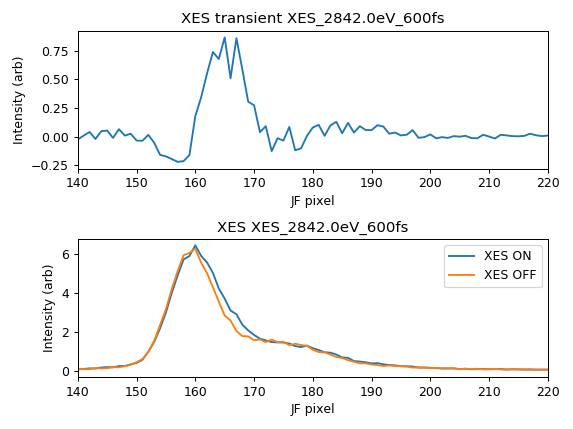

In [8]:
normalize = False



RIXS_trans_01 = (RIXS_on_01-RIXS_off_01)
err_trans_01 = err_adder(err_on_01,err_off_01)
if normalize:
    RIXS_trans_01 = RIXS_trans_01/RIXS_off_01
    err_trans_01 = RIXS_trans_01/RIXS_off_01*err_adder(err_trans_01/RIXS_trans_01,err_off_01/RIXS_off_01)

    
xRange_01 = [140,220]

plt.figure()
plt.subplot(2,1,1)
plt.plot(xAxis,RIXS_trans_01)
plt.fill_between(xAxis,RIXS_trans_01+err_trans_01,RIXS_trans_01-err_trans_01,alpha = 0.2)
plt.xlabel('JF pixel')
plt.ylabel('Intensity (arb)')
plt.title('XES transient '+folder_name_01)
plt.xlim(xRange_01)

plt.subplot(2,1,2)
plt.plot(xAxis,RIXS_on_01, label ='XES ON')
plt.fill_between(xAxis,RIXS_on_01+err_on_01,RIXS_on_01-err_on_01, alpha = 0.2)
plt.plot(xAxis,RIXS_off_01, label = 'XES OFF')
plt.fill_between(xAxis,RIXS_off_01+err_off_01,RIXS_off_01-err_off_01, alpha = 0.2)
plt.xlabel('JF pixel')
plt.ylabel('Intensity (arb)')
plt.title('XES ' +folder_name_01)
plt.xlim(xRange_01)
plt.legend()

plt.tight_layout()


<IPython.core.display.Javascript object>


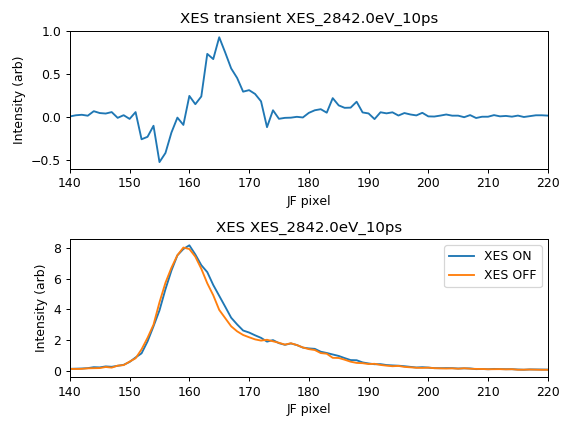

In [9]:
if ynCompare12 == 'yes':
    RIXS_trans_02 = (RIXS_on_02-RIXS_off_02)
    err_trans_02 = err_adder(err_on_02,err_off_02)
    if normalize:
        RIXS_trans_02 = RIXS_trans_02/RIXS_off_02
        err_trans_02 = RIXS_trans_02/RIXS_off_02*err_adder(err_trans_02/RIXS_trans_02,err_off_02/RIXS_off_02)


    xRange_02 = xRange_01

    plt.figure()
    plt.subplot(2,1,1)
    plt.plot(xAxis,RIXS_trans_02)
    plt.fill_between(xAxis,RIXS_trans_02+err_trans_02,RIXS_trans_02-err_trans_02,alpha = 0.2)
    plt.xlabel('JF pixel')
    plt.ylabel('Intensity (arb)')
    plt.title('XES transient '+folder_name_02)
    plt.xlim(xRange_02)

    plt.subplot(2,1,2)
    plt.plot(xAxis,RIXS_on_02, label ='XES ON')
    plt.fill_between(xAxis,RIXS_on_02+err_on_02,RIXS_on_02-err_on_02, alpha = 0.2)
    plt.plot(xAxis,RIXS_off_02, label = 'XES OFF')
    plt.fill_between(xAxis,RIXS_off_02+err_off_02,RIXS_off_02-err_off_02, alpha = 0.2)
    plt.xlabel('JF pixel')
    plt.ylabel('Intensity (arb)')
    plt.title('XES ' +folder_name_02)
    plt.xlim(xRange_02)
    plt.legend()

    plt.tight_layout()

<IPython.core.display.Javascript object>


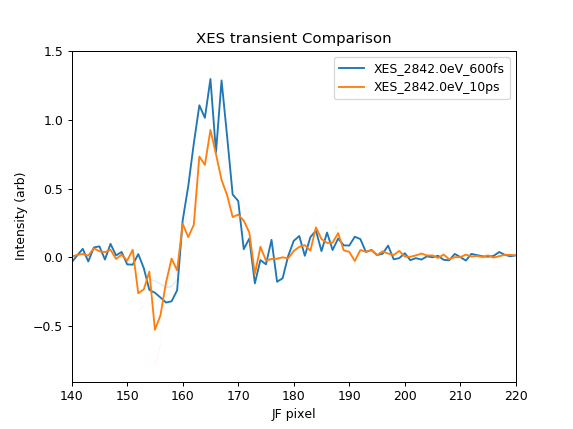

<IPython.core.display.Javascript object>


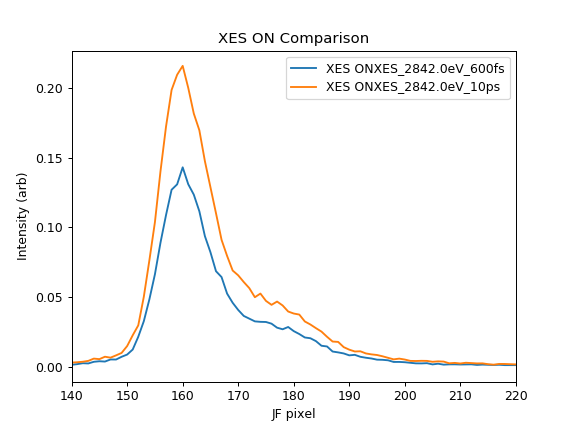

<IPython.core.display.Javascript object>


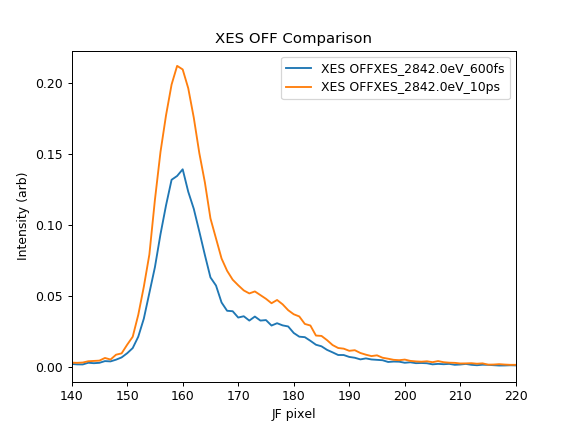

In [10]:
if ynCompare12 == 'yes':
    scale_01 = len(run_list_01)
    scale_02 = len(run_list_02)
    
    
    s_02 = 1.5
    
    plt.figure()        
    plt.plot(xAxis,s_02*RIXS_trans_01, label = folder_name_01)
    plt.fill_between(xAxis,RIXS_trans_01+err_trans_01,RIXS_trans_01-err_trans_01,alpha = 0.2)
    plt.plot(xAxis,RIXS_trans_02, label = folder_name_02)
    plt.fill_between(xAxis,s_02*(RIXS_trans_02+err_trans_02),s_02*(RIXS_trans_02-err_trans_02),alpha = 0.2)
    plt.xlabel('JF pixel')
    plt.ylabel('Intensity (arb)')
    plt.title('XES transient Comparison')
    plt.legend()
    plt.xlim(xRange_02)
    
    
    plt.figure()
    plt.plot(xAxis,RIXS_on_01/scale_01, label ='XES ON'+folder_name_01)
    plt.fill_between(xAxis,(RIXS_on_01+err_on_01)/scale_01,(RIXS_on_01-err_on_01)/scale_01, alpha = 0.2)
    plt.plot(xAxis,s_02*RIXS_on_02/scale_02, label ='XES ON'+folder_name_02)
    plt.fill_between(xAxis,s_02*(RIXS_on_02+err_on_02)/scale_02,s_02*(RIXS_on_02-err_on_02)/scale_02, alpha = 0.2)
    plt.xlabel('JF pixel')
    plt.ylabel('Intensity (arb)')
    plt.title('XES ON Comparison')
    plt.legend()
    plt.xlim(xRange_02)
    
    plt.figure()
    plt.plot(xAxis,RIXS_off_01/scale_01, label ='XES OFF'+folder_name_01)
    plt.fill_between(xAxis,(RIXS_off_01+err_off_01)/scale_01,(RIXS_off_01-err_off_01)/scale_01, alpha = 0.2)
    plt.plot(xAxis,s_02*RIXS_off_02/scale_02, label ='XES OFF'+folder_name_02)
    plt.fill_between(xAxis,s_02*(RIXS_off_02+err_off_02)/scale_02,s_02*(RIXS_off_02-err_off_02)/scale_02, alpha = 0.2)
    plt.xlabel('JF pixel')
    plt.ylabel('Intensity (arb)')
    plt.title('XES OFF Comparison')
    plt.legend()
    plt.xlim(xRange_02)

In [12]:

if True:
    scale_01 = len(run_list_01)
    scale_01 = scale_01*1/2
    red_data_file_01 = '/das/work/p17/p17983/Reduced_data/'+ folder_name_01

    np.save(red_data_file_01+'XES_on',RIXS_on_01/scale_01)
    np.save(red_data_file_01+'XES_on_err',err_on_01/scale_01)
    
    np.save(red_data_file_01+'XES_off',RIXS_off_01/scale_01)
    np.save(red_data_file_01+'XES_off_err',err_off_01/scale_01)
    
    np.save(red_data_file_01+'XES_trans',RIXS_trans_01)
    np.save(red_data_file_01+'XES_trans_err',err_trans_01)
    
if True:
    scale_02 = len(run_list_02)
    scale_02 = scale_02*1/2
    red_data_file_02 = '/das/work/p17/p17983/Reduced_data/'+ folder_name_02
    
    np.save(red_data_file_02+'XES_on',RIXS_on_02/scale_02)
    np.save(red_data_file_02+'XES_on_err',err_on_02/scale_02)
    
    np.save(red_data_file_02+'XES_off',RIXS_off_02/scale_02)
    np.save(red_data_file_02+'XES_off_err',err_off_02/scale_02)
    
    np.save(red_data_file_02+'XES_trans',RIXS_trans_02/scale_02)
    np.save(red_data_file_02+'XES_trans_err',err_trans_02/scale_02)
    
    

    
    
